# Flax-Pilot Classifer MNIST with BatchNorm Notebook

This notebook demonstrates the usage of flax-pilot to train a Classifier. The workflow uses distributed training using jax.pmap on Kaggle GPU

**Use TensorFlow-cpu instead of TensorFlow to avoid any issues between TensorFlow & Jax.**

In [1]:
!pip install -q tensorflow-cpu

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.4.1 which is incompatible.
tensorflow 2.15.0 requires ml-dtypes~=0.2.0, but you have ml-dtypes 0.4.0 which is incompatible.
tensorflow 2.15.0 requires tensorboard<2.16,>=2.15, but you have tensorboard 2.17.0 which is incompatible.


In [2]:
!pip install -q mergedeep

In [3]:
import jax
import optax
import tensorflow as tf
import flax.linen as nn
import jax.numpy as jnp
import jax.random as jr

In [4]:
import jax, flax, orbax.checkpoint
jax.__version__, flax.__version__, orbax.checkpoint.__version__

('0.4.26', '0.8.4', '0.5.20')

### Create a simple Classifier Model.

*Note: The main model must always have a '**deterministic**' param to handle layers like dropout & batchnorm. Not adding '**deterministic**' param will lead to error as flax-pilot always expects this param, irrespective of whether the model has any stochastic layers or not.*

In [5]:
class CNN(nn.Module):
    
  # When calling the model's `__call__` with internal state layers, the function will return output & internal state's updates.  
  @nn.compact
  def __call__(self, x, deterministic):
    # determinisitic: True means validation and False means training.
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.BatchNorm(use_running_average=deterministic)(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  
    x = nn.Dense(features=256)(x)
    x = nn.Dropout(rate=0.3, deterministic=deterministic)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

### Create tf.data.Dataset
Distributed training in this notebook is performed using jax.pmap. jax.pmap expects the first dimension of its input tensor as the number of devices in parallel.<br>
<br> 
So Input tensor must have shape **(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)**<br>
MNIST Images have shape : **(28, 28, 1)**<br>
In this case, input shape will be : **(2, 128, 28, 28, 1)**. So, we have 2 devices, each device will receive a batch of shape **(128, 28, 28, 1)**.

GLOBAL_BATCH_SIZE = LOCAL_BATCH_SIZE * NO_OF_DEVICES<br>
In this case, GLOBAL_BATCH_SIZE = 256

In [6]:
(x_train, y_train), (x_val, y_val) = tf.keras.datasets.mnist.load_data()

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = train_ds.shuffle(256).batch(128, True)
train_ds = train_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)

# Second batching for distributing with pmap.
train_ds = train_ds.batch(2, True)
train_ds = train_ds.repeat().as_numpy_iterator()

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_ds = val_ds.shuffle(256).batch(128, True)
val_ds = val_ds.map(lambda x, y: (tf.expand_dims(x, -1)/255, tf.one_hot(y, 10)), num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(2, True)
val_ds = val_ds.repeat().as_numpy_iterator()

train_ds, val_ds

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


(NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78372b04b5b0>),
 NumpyIterator(iterator=<tensorflow.python.data.ops.iterator_ops.OwnedIterator object at 0x78372aeed210>))

### Loss Function

#### Inputs to the loss function

##### The `loss_fn` will always receive these 7 specific inputs, described as follows:

1. **params**:
   - **Description**: The model's parameters.
   - **Obtained by**: Using the `init` method of `flax.linen.Module`.
   - **Example**: `params = model.init(prng_key, input_shape)`.


2. **variables**
   - **Description**: Internal variables of model's layers (not weights).
   - **Example**: mean and var of batchnorm layers.
   - **Usage**: This param must be ignored if the model doesn't have any internal variables. The presence of this param in the loss_metric_fn header when there's no internal state in the model will result in errors.
   
   
3. **apply**:
   - **Description**: The `apply` method from `flax.linen.Module`, used to call other methods within the module.



4. **sample**:
   - **Description**: The input data to the model.


5. **deterministic**:
   - **Description**: Indicates whether to enable deterministic behavior in layers (similar to the `training` parameter in Keras).
   - **Usage**: 
     - Set to `True` during validation (`val_step`), where dropout is disabled.
     - Set to `False` during training (`train_step`).




. **global_key**:
   - **Description**: A PRNGKey used to seed random variables, important for dropout and other random operations within the model.
   - **Management**: 
     - Updated using `jax.fold_in` within the `train_step` and `val_step` functions to ensure a unique key for each step.
     - When flax model requires multliple keys in its forward pass, the global prng key received here can be splitted into multliple prng keys using `jax.random.split`. These splits can be represented as a dict where keys of the dict are the `rng_name` used from within the model using `self.make_rng(rng_name)` and value as the prng key itself.
     - From within the model, prng keys can be accessed by `self.make_rng(rng_name)`.
     
     
    
7. **step**:
   - **Description**: Represents the current iteration or step number of the optimizer during training.
   - **Usage**: Can be used to weigh losses based on the current number of iterations. For example, it allows implementing techniques like annealing the KL divergence weight in a variational autoencoder or any other time-dependent adjustments during training.
   - **Management**:
     - Passed directly to the `loss_fn` within the `train_step` and `val_step` functions.
     - It is incremented at each iteration of the training loop.
     - Enables dynamic adjustments of the loss function or other training parameters as training progresses, offering more fine-grained control over the training process.


### Note:
- All these 7 parameters are crucial for training and must not be removed or replaced.
- Their names can be changed, but their order and functionality must remain the same.



This structure ensures that the `loss_fn` receives all necessary inputs in a consistent manner, facilitating proper model training and evaluation.

#### Outputs from the loss function

The function must return 3 elements:

1. **Scalar loss**:
   - **Description**: The value which should be minimized.
   - **Details**: This scalar is minimized with respect to the first parameter of the function, `params`.


2. **Variables**:
   - **Description**: Updates of internal variables of model.
   - **Details**: This param is the updates of internal state of model. Some layers like batchnorm holds internal states and this variable holds the updates of those layers.
   - **Usage**: When model doesn't have any internal states, the loss fn must return only the scalar loss & loss metric values dict. Not doing so will result in errors.


3. **loss_metric_values_dict**:
   - **Description**: A dictionary that must always contain two keys, **'mt'** (metric tracker) and **'lt'** (loss tracker).
   - **Structure**:
     - Each of these parent keys must hold a child dictionary as its value, representing different metric and loss trackers.
     - The child dictionary's key names can be any string but must match with the tracker instances dictionary (explained in later cells).
     - The child dictionary's values must be the values being tracked.
   - **Details**:
     - For losses, the loss tracker is used to track the losses, so the child dictionaries of **'lt'** must have scalar loss as their values.
     - For classification metrics like Accuracy or F1Score, the child dictionary of **'mt'** will expect a tuple of `(y_true, y_pred)` as its value or a dictionary like `{'true': true, 'pred': pred}` as its value.
     - These values of child dict are passed to the `update` function of tracker instances. Check out `trackers.py` to understand the expected inputs of each tracker's update function.

In [7]:
def loss_fn(params, variables, apply, sample, deterministic, global_key, step):
    x, y = sample
    yp, updates = apply(params | variables, x, deterministic=deterministic, rngs={'dropout': global_key}, mutable=list(variables.keys()))
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp), 'pre': (y, yp), 'rec': (y, yp)}
    }
    return loss, updates, loss_metric_values_dict


#### When training model without layers like Internal state layers (BatchNorm), one must not have `variables` param in the function header and also one must only return the scalar loss and loss metric dict. So the function must look like this.

```python
def loss_fn(params, apply, sample, deterministic, global_key, step):
    x, y = sample
    yp = apply(params, x, deterministic=deterministic, rngs={'dropout': global_key})
    loss = optax.softmax_cross_entropy(yp, y).mean()
    yp = nn.softmax(yp, axis=-1)
    loss_metric_values_dict = {
        'lt': {'loss': loss},
        'mt': {'f1': (y, yp), 'acc': (y, yp), 'pre': (y, yp), 'rec': (y, yp)}
    }
    return loss, loss_metric_values_dict


```

### Access to the modules

In [8]:
import os
os.listdir("/kaggle/input/fpilot")

['trackers', 'checkpoints', 'opt_utils', 'training']

In [9]:
import glob, sys
sys.path.append("/kaggle/input")

### Creating tracker functions

Trackers are represented in a dictionary, with keys **'mt'** (metric tracker) and **'lt'** (loss tracker) being mandatory. Each of these keys must have a child dictionary as its value. The child dictionary's key names must match the child key names in `loss_metric_values_dict`. The value of the child dictionaries must be tracker instances.


In [10]:
import fpilot.trackers.basic_trackers as tr

trackers = {
        'lt': {'loss': tr.Mean()},
        'mt':{'f1': tr.F1Score(num_classes=10, threshold=0.7, average='macro'), 'acc': tr.Accuracy(),
              'pre': tr.Precision(num_classes=10, threshold=0.7, average='micro'),
              'rec': tr.Recall(num_classes=10, threshold=0.7, average='macro')
             }
}

### Trainer

The `Trainer` instance takes in five parameters:

1. **flax_model**:
   - **Description**: A `flax.linen.Module` instance.



2. **input_shape**:
   - **Description**: Shapes of input tensors passed to the model.
   - **Type**: A dictionary where the key is the parameter name of the model's `__call__` method and the value is the shape of the tensor.



3. **optimizer**:
   - **Description**: 
     - In single-objective training: It must be a single Optax optimizer. This optimizer is applied uniformly to all model parameters to minimize the loss function.
     - In multi-objective training (e.g., GANs): It must be a dictionary of optimizers. The keys of this dictionary correspond to the parameter's key  in the Flax `TrainState.params` that need to be optimized, and the values are the respective Optax optimizers for those parameters. This allows different sets of parameters to be optimized with different strategies.



4. **loss_metric_fn**:
   - **Description**: The loss function as explained above.



5. **trackers**:
   - **Description**: A dictionary of trackers as explained in the previous cell.

In [36]:
from fpilot.training.trainer import Trainer

trainer = Trainer(CNN(), {'x': (1, 28, 28, 1)}, optax.adam(0.001), loss_fn, trackers)

Check the docstring of **Trainer.train** for explaination 

In [13]:
trainer.train(3, train_ds, val_ds, 60000//256, 10000//256, '/kaggle/working/BatchNorm/classifier', 3)

Epoch 1: 100%|██████████| 234/234 [00:00<00:00, 338.52it/s]


Train:  loss: 0.037645567, acc: 0.9884315, f1: 0.9863685, pre: 0.99371564, rec: 0.9791791, time: 0.6941990852355957
Val:  loss: 0.028022904, acc: 0.9901843, f1: 0.9891133, pre: 0.99513507, rec: 0.9832188, time: 0.07935571670532227
State saved..


Epoch 2: 100%|██████████| 234/234 [00:00<00:00, 341.97it/s]


Train:  loss: 0.03163909, acc: 0.98963344, f1: 0.9883186, pre: 0.99497586, rec: 0.9817835, time: 0.688143253326416
Val:  loss: 0.03505564, acc: 0.9881811, f1: 0.9872796, pre: 0.9930116, rec: 0.9818099, time: 0.09331774711608887
State saved..


Epoch 3: 100%|██████████| 234/234 [00:00<00:00, 372.66it/s]


Train:  loss: 0.026363093, acc: 0.99172014, f1: 0.99048054, pre: 0.9958496, rec: 0.9852149, time: 0.6311745643615723
Val:  loss: 0.027854297, acc: 0.99138623, f1: 0.9899096, pre: 0.9939428, rec: 0.98608714, time: 0.08238339424133301
State saved..


### Check the BatchNorm stats

In [42]:
trainer.state.variables

{'variables': {'batch_stats': {'BatchNorm_0': {'mean': Array([[ 0.00654129, -0.07639657, -0.3029941 ,  0.13911673,  0.17956237,
            -0.0136447 ,  0.02212795,  0.16602078, -0.01601914,  0.12336694,
             0.01872988, -0.18672651, -0.00654524,  0.02779718,  0.023746  ,
             0.14630586,  0.02032734, -0.0170386 ,  0.07133616, -0.00806463,
             0.00380964,  0.09744951, -0.18801993, -0.01304001, -0.00264781,
            -0.00121047, -0.00777557, -0.2718615 ,  0.03266473,  0.18029079,
            -0.04740056, -0.00375164],
           [ 0.00654129, -0.07639657, -0.3029941 ,  0.13911673,  0.17956237,
            -0.0136447 ,  0.02212795,  0.16602078, -0.01601914,  0.12336694,
             0.01872988, -0.18672651, -0.00654524,  0.02779718,  0.023746  ,
             0.14630586,  0.02032734, -0.0170386 ,  0.07133616, -0.00806463,
             0.00380964,  0.09744951, -0.18801993, -0.01304001, -0.00264781,
            -0.00121047, -0.00777557, -0.2718615 ,  0.03266473,

### Access any method of the model

To access methods of the model, one can call the Trainer instance. **Check docstring to understand its working.**
<br>The params are explained below

1. **rngs**:
   - **Description**: A dictionary where the values are `jax.random.PRNGKey` instances and the keys are the names used inside the model to reference these PRNGKeys.



2. **tensor_inputs**:
   - **Description**: The tensor inputs passed to the model's method you plan to call.
   - **Type**: A dictionary where each key is the name of a method parameter and each value is the corresponding tensor input.
   - **Note**: Tensor inputs must include a device dimension due to `jax.pmap` decoration, e.g., `(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)`.



3. **method**:
   - **Description**: A string representing the method of the model you plan to call.
   - **Default**: The default value is the `__call__` method.



4. **kwargs**:
   - **Description**: Used to pass any static arguments to the method, such as the `deterministic` parameter.



Below are some examples.

*Note: Tensor inputs to methods are jax.pmap decorated so, inputs must include device dimension. For ex. __(NO_OF_DEVICES, LOCAL_BATCH_SIZE, ...)__*

#### Model call
The callable Trainer function accepts param '**method**' which represents the which method of the model to call. Default value is the **call** method.

In [40]:
sample = next(val_ds)
x, y = sample[0][:, :8], sample[1][:, :8]

rngs = {} # no rng needed bcz prediction doesnt require dropout
tensor_inputs = {'x': x}

# No internal state updates are returned bcz this is inference(determinsitic=True).
yp = trainer(rngs, tensor_inputs, deterministic=True)

yp = nn.softmax(yp, axis=-1).argmax(axis=-1)

### Evaluate the model

In [39]:
trainer.evaluate(val_ds, 10000//256)

Val:  loss: 0.027451826, acc: 0.99158657, f1: 0.99004984, pre: 0.9940437, rec: 0.9862586, time: 0.9068570137023926


### Compute trackers

In [38]:
trainer.compute_trackers()

{'lt': {'loss': Array([0.02908804, 0.02908804], dtype=float32)},
 'mt': {'acc': Array([0.99138623, 0.99138623], dtype=float32),
  'f1': Array([0.9891947, 0.9891947], dtype=float32),
  'pre': Array([0.99333596, 0.99333596], dtype=float32),
  'rec': Array([0.98533756, 0.98533756], dtype=float32)}}

### Save & Load checkpoints

In [20]:
# args: location to save checkpoint
trainer.save_state('/kaggle/working/bn_class/mnist')

State saved..


In [37]:
# args: path to saved checkpoint folder, step number of checkpoint to restore
trainer.load_state('/kaggle/working/bn_class/mnist', 1404)

### Visualize results

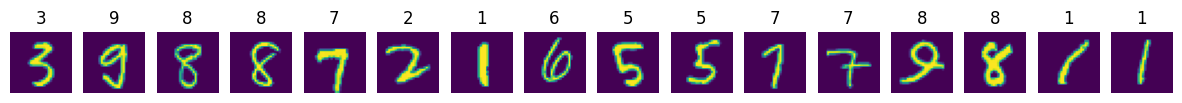

In [41]:
import matplotlib.pyplot as plt

yp = yp.reshape(16, -1)
x = x.reshape(16, 28, 28, 1)

plot_images = iter(x)
labels = iter(yp)
fig, ax = plt.subplots(1, 16, figsize=(15, 15))

for i in range(16):
        ax[i].imshow(next(plot_images))
        ax[i].set_title(str(next(labels)[0]))
        ax[i].axis('off')